In [1]:
# from sdRDM.generator import generate_python_api

In [2]:
# generate_python_api("specifications/enzymepynetics.md", "", "EnzymePynetics")

In [3]:
%reload_ext autoreload
%autoreload 2

from EnzymePynetics import Estimator

## Initialize the Estimator from an EnzymeML document

In [4]:
e, enzymeml = Estimator.from_enzymeml(
    enzymeml="/Users/max/Documents/GitHub/MTPHandler/MTPHandler/examples/kinetics_substrate.json",
    measured_reactant="ABTS",
)

abts, abts_radical = e.reactants[1:]
slac = e.enzymes[0]

## Define the reaction

In [5]:
oxidation = e.add_reaction(
    id="r1", name="Oxidation", educt=abts, product=abts_radical, enzyme=slac
)

## Add a kinetic models

In [6]:
michaelis = e.add_model(
    id="model1",
    name="michaelis-menten",
    equation="substrate = -substrate * enzyme * k_cat / (K_m + substrate)",
)

enzyme_inactivation = e.add_model(
    id="model2",
    name="enzyme inactivation",
    equation="enzyme = -k_ie * enzyme ",
)

competitive_product = e.add_model(
    id="model3",
    name="competitive product inhibition",
    equation="substrate = -substrate * enzyme * k_cat / (K_m * (1 + product / K_ic) + substrate)",
)

substrate_inhibition = e.add_model(
    id="model4",
    name="substrate inhibition",
    equation="substrate = -k_cat * enzyme * substrate / (K_m + ((1+(substrate/K_iu))*substrate))",
)

In [7]:
e.fit_models()

/Users/max/Documents/GitHub/software-driven-rdm/sdRDM/base/datamodel.py:332: UserWarning: No 'URL' and 'Commit' specified. This model might not be re-usable.
  warnings.warn(


Fitting michaelis-menten
Fitting michaelis-menten with enzyme inactivation
Fitting competitive product inhibition
Fitting competitive product inhibition with enzyme inactivation
Fitting substrate inhibition
Fitting substrate inhibition with enzyme inactivation


,AIC,k_cat,K_m,K_ic,K_iu,k_ie
,,1 / min,umol / l,umol / l,umol / l,1 / min
Model,,,,,,
michaelis-menten with enzyme inactivation,2044,1610.25,99999.98,,,0.17
competitive product inhibition with enzyme inactivation,2051,1614.23,99999.97,10000.00,,0.17
michaelis-menten,2499,782.87,99999.90,,,
competitive product inhibition,2502,786.06,99999.85,10000.00,,
substrate inhibition,failed,,,,,
substrate inhibition with enzyme inactivation,failed,,,,,


## Problems:

- Apparently no activity in reactions with low initial ABTS
- Product absorbs at 340 nm, --> only apparent decrease in reaction rate

In [8]:
e.visualize()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set the Matplotlib LaTeX preamble to include the amsmath package

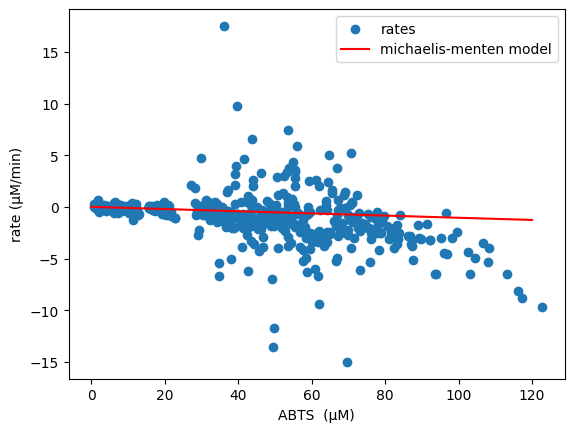

In [10]:
nan_mask = np.isnan(e.substrate_data).any(axis=1)


def mm_model(s, e, k_cat, K_m):
    return -e * k_cat * s / (K_m + s)


substrates = e.substrate_data[~nan_mask]
init_subsrates = e.init_substrate_data[~nan_mask]

np.diff(substrates)
plt.scatter(substrates[:, :-1], (np.diff(substrates)), label="rates")
plt.plot(
    np.linspace(0, 120, 100),
    mm_model(np.linspace(0, 120, 100), 6.55, 1610, 999999),
    color="red",
    label="michaelis-menten model",
)
# plt.plot(np.linspace(0,120,100), mm_model(np.linspace(0,120,100), 6.55, 3, 40), color="red", label="michaelis-menten model")
plt.ylabel("rate (µM/min)")
plt.xlabel("ABTS  (µM)")
plt.legend()
plt.show()

## Funny simulation

In [11]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import plotly.express as px

entries = []
for e in np.linspace(0.00001, 25, 50):

    def menten(substrate, t, k_cat, K_m, enzyme):
        ds = -substrate * enzyme * k_cat / (K_m + substrate)
        return ds

    def simulate(substrate, t, params):
        k_cat, K_m, enzyme = params
        result = odeint(menten, substrate, t, args=(k_cat, K_m, enzyme))
        return result

    time = np.linspace(0, 40, 41)

    params = (1, 25, e)

    result = simulate(100, time, params).T[0]

    for t, s in zip(time, result):
        entries.append({"time": t, "substrate": s, "enzyme": e})

df = pd.DataFrame(entries)

fig = px.scatter(df, x="time", y="substrate", animation_frame="enzyme")
fig.update_layout(yaxis_range=[0, 100])
fig.update_layout(xaxis_range=[0, 40])

fig.show()